In [ ]:
pip install kagglehub


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pascal-voc-2012-dataset' dataset.
Path to dataset files: /kaggle/input/pascal-voc-2012-dataset


In [5]:
import os
from PIL import Image

data_path = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages"

sample = os.listdir(data_path)[:5]
print("Ejemplos:", sample)

img = Image.open(os.path.join(data_path, sample[0]))
img.show()


Ejemplos: ['2007_005304.jpg', '2009_002094.jpg', '2011_006475.jpg', '2011_000611.jpg', '2009_004042.jpg']


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import xml.etree.ElementTree as ET


In [20]:
class PascalVOCDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annots_dir, transform=None):
        self.images_dir = images_dir
        self.annots_dir = annots_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]

        self.classes = [
            'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
            'bus', 'car', 'cat', 'chair', 'cow',
            'diningtable', 'dog', 'horse', 'motorbike', 'person',
            'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        annot_path = os.path.join(self.annots_dir, img_name.replace(".jpg", ".xml"))

        image = Image.open(img_path).convert("RGB")

        # Extraer primera etiqueta del XML
        tree = ET.parse(annot_path)
        root = tree.getroot()
        label_name = root.find("object/name").text
        label = self.classes.index(label_name)

        if self.transform:
            image = self.transform(image)

        return image, label

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

images_dir = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages"
annots_dir = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/Annotations"

dataset = PascalVOCDataset(images_dir, annots_dir, transform)

# División 80/20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo preentrenado
model = models.resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False  # Congela las capas base

# Reemplazar la capa final (para 20 clases del Pascal VOC)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 75.7MB/s]


In [23]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Época {epoch+1}/{num_epochs} | Pérdida: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

Época 1/10 | Pérdida: 1.1416 | Accuracy: 0.6795
Época 2/10 | Pérdida: 0.8326 | Accuracy: 0.7482
Época 3/10 | Pérdida: 0.7949 | Accuracy: 0.7604
Época 4/10 | Pérdida: 0.7684 | Accuracy: 0.7653
Época 5/10 | Pérdida: 0.7470 | Accuracy: 0.7707
Época 6/10 | Pérdida: 0.7335 | Accuracy: 0.7719
Época 7/10 | Pérdida: 0.7224 | Accuracy: 0.7748
Época 8/10 | Pérdida: 0.7108 | Accuracy: 0.7789
Época 9/10 | Pérdida: 0.6967 | Accuracy: 0.7816
Época 10/10 | Pérdida: 0.7077 | Accuracy: 0.7766


In [24]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_true, y_pred, average="macro")

print("\n Evaluación del modelo:")
print(f" Accuracy:  {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1-score:  {f1:.4f}")


 Evaluación del modelo:
 Accuracy:  0.7658
 Precision: 0.7050
 Recall:    0.6737
 F1-score:  0.6814



📋 Reporte de Clasificación:
              precision    recall  f1-score   support

   aeroplane       0.87      0.91      0.89       142
     bicycle       0.77      0.71      0.74        87
        bird       0.92      0.83      0.87       167
        boat       0.76      0.82      0.79        84
      bottle       0.58      0.45      0.50        74
         bus       0.74      0.85      0.79        79
         car       0.77      0.62      0.68       151
         cat       0.82      0.89      0.86       216
       chair       0.65      0.26      0.37       125
         cow       0.56      0.76      0.64        59
 diningtable       0.46      0.44      0.45        57
         dog       0.89      0.78      0.83       218
       horse       0.62      0.62      0.62        98
   motorbike       0.66      0.65      0.65        82
      person       0.79      0.87      0.83      1387
 pottedplant       0.45      0.43      0.44        46
       sheep       0.85      0.66      0.74        7

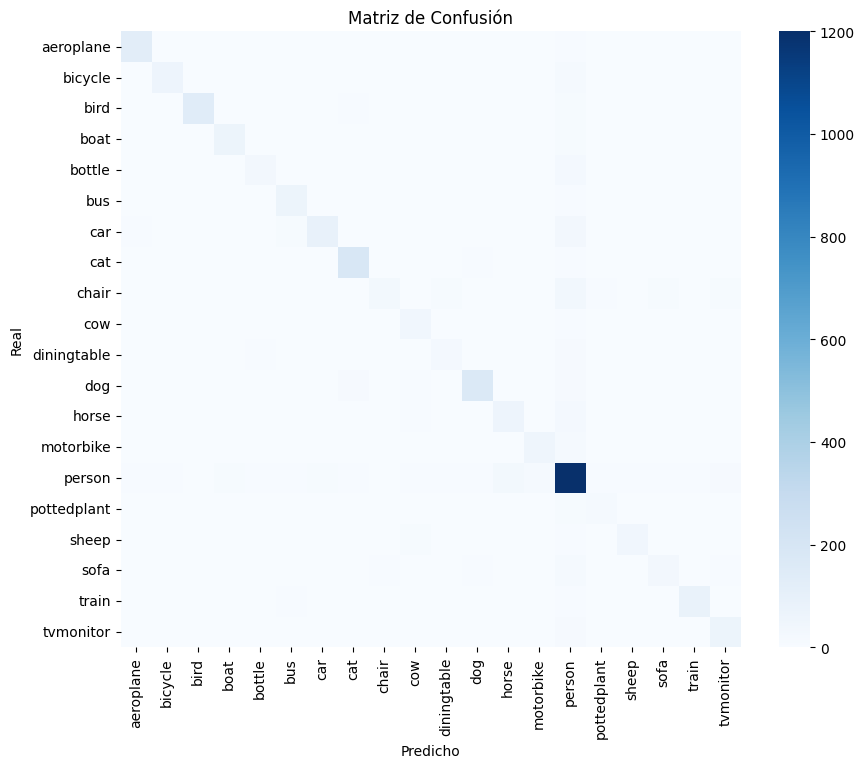

In [25]:
class_names = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

print("\n📋 Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

In [31]:
pip install onnxpip install onnx-tf

ERROR: Could not find a version that satisfies the requirement onnxpip (from versions: none)
ERROR: No matching distribution found for onnxpip


In [33]:
!pip install onnx onnx-tf tensorflow

INFO: pip is looking at multiple versions of onnx-tf to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 6.1 MB/s eta 0:00:00


In [34]:
!onnx-tf convert -i resnet18_voc.onnx -o resnet18_voc_tf

2025-11-15 19:30:54.276337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763235054.296261   20907 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763235054.302214   20907 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763235054.317738   20907 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763235054.317769   20907 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763235054.317772   20907 computation_placer.cc:177] computation placer alr

In [36]:
import os

os.listdir(".")

['.config', 'resnet18_voc.onnx', 'data', 'sample_data']

In [2]:
pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.9 MB/s eta 0:00:00


# Pruebas

In [6]:
import onnxruntime as ort
from PIL import Image
import numpy as np

# Cargar modelo
session = ort.InferenceSession("resnet18_voc.onnx")

# Mostrar nombres de entrada y salida
print("Entradas:", session.get_inputs())
print("Salidas:", session.get_outputs())

# Preprocesamiento de imagen
img = Image.open("gato.jpeg").convert("RGB").resize((224, 224))
img_np = np.array(img).astype(np.float32) / 255.0

# Normalización (ImageNet)
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img_np = (img_np - mean) / std

# Reordenar a formato (1, 3, 224, 224)
img_np = np.transpose(img_np, (2, 0, 1))[np.newaxis, :, :, :].astype(np.float32)

# Ejecutar inferencia
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_np})

# Interpretar resultados
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

pred_idx = np.argmax(outputs[0])
print("Clase predicha:", VOC_CLASSES[pred_idx])


Entradas: [<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x78c85cfa8c30>]
Salidas: [<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x78c85cfa8c70>]
Clase predicha: cat
